# Construction of a prediction model for Covid19
## Part 2 of the notebook (for part one look at the fork of covidclinicaldata

In [118]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import eli5

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.dummy import DummyClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

shap.initjs() #So shap values can be displayed inline

In [2]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

,covid19_test_results,age,high_risk_exposure_occupation,high_risk_interactions,diabetes,chd,htn,cancer,asthma,autoimmune_dis,...,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,Negative,4,True,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
1,Negative,2,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
2,Negative,1,NaN,NaN,False,False,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Negative,3,True,True,False,False,False,False,False,False,...,True,2.0,False,True,False,False,False,False,False,True
4,Negative,1,False,NaN,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93990,Negative,3,False,True,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,True,False,True
93991,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False
93993,Negative,3,False,False,False,False,False,False,False,False,...,False,0.0,False,False,False,False,False,False,False,False


In [3]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]

In [4]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10:16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 16:21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [5]:
e_factors, comorb, vitals, a_symptoms, r_symptoms = create_different_datasets(X)

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [6]:
def high_risk_exposure_imputation(data_x, data_y, target_imputation=False):    
    if target_imputation:
        mode = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]
    else:
        mode = True
    data_x.loc[data_x["high_risk_exposure_occupation"].isna(), "high_risk_exposure_occupation"] = mode
    
    data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]

def vitals_imputation_generic(data_x):
    data = data_x.copy()
    data.loc[data["temperature"].isna(),"temperature"] = data["temperature"].mean()
    data.loc[data["pulse"].isna(),"pulse"] = data["pulse"].median()
    data.loc[data["rr"].isna(),"rr"] = data["rr"].median()
    data.loc[data["sats"].isna(),"sats"] = data["sats"].median()
    data.loc[data_x["pam"].isna(), "pam"] = data_x["pam"].mean()
    
    return data


In [7]:
def reduce_training_set(data_x, data_y):
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum())
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def specificity_score(*values):    
    cm = confusion_matrix(*values)    
    return cm[0][0] / (cm[0][0] + cm[0][1]) 


def get_metrics(*values):
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    specificity = specificity_score(*values)
    return accuracy, recall, precision, specificity, f1 


In [8]:
class Imputer():
    
    def __init__(self):
        self.column_values = {}
        
    def fit_transform(self, data_x, data_y):
        self.fit(data_x, data_y)
        self.transform(data_x, training=True)
        
    def fit(self, data_x, data_y):
        self.get_high_risk_exposure_value(data_x, data_y)
        self.get_vitals_values(data_x)
        self.get_a_symptoms_values(data_x)
        self.get_r_symptoms_values(data_x)
        
    def transform(self, data_x, training=False):
        for feature in data_x.columns:           
            
            if feature in self.column_values:
                new_value = self.column_values[feature]
                
                if feature == "high_risk_exposure_occupation" and not training:
                    new_value=True
                    
                data_x.loc[data_x[feature].isna(), feature] = new_value
                
        if "high_risk_interactions" in data_x.columns: #Because this depends on 'high_risk_exposure_occupation being imputed first'
            data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]
        
        
        
    def get_high_risk_exposure_value(self, data_x, data_y):
        if "high_risk_exposure_occupation" in data_x.columns:
            self.column_values["high_risk_exposure_occupation"] = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]

        
    def get_vitals_values(self, data_x):
        if "temperature" in data_x.columns:
            self.column_values["temperature"] =  data_x["temperature"].mean()
        if "pulse" in data_x.columns:
            self.column_values["pulse"] = data_x["pulse"].median()
        if "rr" in data_x.columns:
            self.column_values["rr"] = data_x["rr"].median()
        if "sats" in data_x.columns:
            self.column_values["sats"] = data_x["sats"].median()
        if "pam" in data_x.columns:
            self.column_values["pam"] =  data_x["pam"].mean()
            
    def get_a_symptoms_values(self, data_x):
        
        if "ctab" in data_x.columns:
            self.column_values["ctab"] = data_x["ctab"].mode()[0]
            
        if "labored_respiration" in data_x.columns:
            self.column_values["labored_respiration"] = data_x["labored_respiration"].mode()[0]
            
        if "rhonchi" in data_x.columns:
            self.column_values["rhonchi"] = data_x["rhonchi"].mode()[0]
            
        if "wheezes" in data_x.columns:
            self.column_values["wheezes"] = data_x["wheezes"].mode()[0]
            
        if "days_since_symptom_onset" in data_x.columns:
            self.column_values["days_since_symptom_onset"] = data_x["days_since_symptom_onset"].median()
            
    def get_r_symptoms_values(self, data_x):
        if "cough" in data_x.columns:
            self.column_values["cough"] = data_x["cough"].mode()[0]
            
        if "cough_severity" in data_x.columns:
            self.column_values["cough_severity"] = data_x["cough_severity"].mode()[0]
            
        if "fever" in data_x.columns:
            self.column_values["fever"] = data_x["fever"].mode()[0]
            
        if "sob" in data_x.columns:
            self.column_values["sob"] = data_x["sob"].mode()[0]
            
        if "sob_severity" in data_x.columns:
            self.column_values["sob_severity"] = data_x["sob_severity"].mode()[0]
        
        if "diarrhea" in data_x.columns:
            self.column_values["diarrhea"] = data_x["diarrhea"].mode()[0]
            
        if "fatigue" in data_x.columns:
            self.column_values["fatigue"] = data_x["fatigue"].mode()[0]
            
        if "headache" in data_x.columns:
            self.column_values["headache"] = data_x["headache"].mode()[0]
            
        if "loss_of_smell" in data_x.columns:
            self.column_values["loss_of_smell"] = data_x["loss_of_smell"].mode()[0]
            
        if "loss_of_taste" in data_x.columns:
            self.column_values["loss_of_taste"] = data_x["loss_of_taste"].mode()[0]
    
        if "runny_nose" in data_x.columns:
            self.column_values["runny_nose"] = data_x["runny_nose"].mode()[0]
            
        if "muscle_sore" in data_x.columns:
            self.column_values["muscle_sore"] = data_x["muscle_sore"].mode()[0]
            
        if "sore_throat" in data_x.columns:
            self.column_values["sore_throat"] = data_x["sore_throat"].mode()[0]

In [9]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y, sample_weight=None):
        self.model.fit(self.xgb_adapter(data_x), data_y, sample_weight=sample_weight)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
    
    def predict_proba(self, data_x):
        return self.model.predict_proba(self.xgb_adapter(data_x))
    
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [10]:
def calculate_shap_values(model, data_x):
    explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
    sample = data_x.sample(1)
    display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
    
def permutation_importance(model, X, Y, num_shuffles=50):
    feature_score_difference = np.full((len(X.columns), num_shuffles), 0, dtype=float)
    og_predictions = model.predict(X)
    og_error = accuracy_score(Y, og_predictions)
    for i in range(len(X.columns)): # Para cada feature
        feature = X.columns[i]
        shuffled_values = pd.DataFrame(X, copy = True) # Para que no afecte el dataset original solo copiamos los valores
        for j in range(num_shuffles):
            np.random.shuffle(shuffled_values[feature].values)
            col_preds = model.predict(shuffled_values)
            col_error = accuracy_score(Y, col_preds)
            feature_score_difference[i][j] = col_error - og_error # og tiene que ser mas pequeño
    result_table = np.array([feature_score_difference.mean(axis=1), feature_score_difference.std(axis=1)])
    
    df = pd.DataFrame(np.transpose(result_table), columns=["Importancia", "Desviacion estándar"], index=X.columns)
    return df.sort_values(by="Importancia", ascending = False)

In [171]:
def cross_validation_normal(data_x, data_y, model, folds, sample_weights=None):
    results = np.zeros((folds,2,5)) #Shape of folds, training and validation, and number of metrics
    if sample_weights is None:
        sample_weights = np.ones(data_y.shape)
       
    fold_size = data_x.shape[0] // folds
    reminder = data_x.shape[0] % folds    
    start = 0    
    imputer = Imputer()
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1
        train_x = pd.concat([data_x.iloc[:start], data_x.iloc[end:]], axis=0)
        train_y = data_y.iloc[:start].append(data_y.iloc[end:])
        valid_x = data_x.iloc[start:end]
        valid_y = data_y.iloc[start:end]
                    
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
            
        model.fit(train_x, train_y, sample_weight=np.append(sample_weights[:start], sample_weights[end:]))
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v)
        results[i,1] += get_metrics(*valid_v)
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")    
       
    
    return results.mean(axis=0)



def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = positive_index.shape[0] * ratio_negatives_to_positives
    
    fold_size = positive_index.shape[0] // folds
    results = np.zeros((folds,2,6)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = Imputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(size_of_negatives - fold_size), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        valid_x = pd.concat([data_x[data_y == "Negative"].sample(fold_size * ratio_negatives_to_positives), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
        
            
        model.fit(train_x, train_y)
        train_v = (train_y, model.predict(train_x))
        valid_v = (valid_y, model.predict(valid_x))
        results[i,0] += get_metrics(*train_v) + (roc_auc_score(train_y, model.predict_proba(train_x)[:,1]),) ## We choose '1' in predict_proba since that is the positive class
        results[i,1] += get_metrics(*valid_v) + (roc_auc_score(valid_y, model.predict_proba(valid_x)[:,1]),) ## We choose '1' in predict_proba since that is the positive class
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
                    
    print("")
    
    try:

        train_shap_x = pd.concat([data_x[data_y == "Negative"].sample((size_of_negatives - fold_size) // 2), data_x.loc[positive_index].sample((size_of_negatives - fold_size) // 2)], axis=0)
        
        test_shap_x = data_x.loc[np.setdiff1d(data_x.index.values, train_shap_x.index.values)].sample(fold_size)

        imputer.fit_transform(train_shap_x, data_y[train_shap_x.index])
        imputer.transform(test_shap_x)
        model.fit(train_shap_x, data_y[train_shap_x.index])
        #explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
        #sample = data_x.sample(fold_size)
        #display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
        #display(permutation_importance(model, test_shap_x, y[test_shap_x.index], 5)) ## Doesn't seem to be working very well
        display(eli5.show_weights(model, feature_names=list(data_x.columns)))
        
        roc_values = roc_curve(data_y[test_shap_x.index], model.predict_proba(test_shap_x)[:,1], pos_label="Positive", drop_intermediate=False)
        plt.plot(roc_values[0], roc_values[1], 'b-')
        plt.show()
        
        
    except Exception as e:
        print(e)
    
    
    return results.mean(axis=0)

   
        
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1, sample_weights=None):
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        try:
            if(ratio_negatives_to_positives >= 1):            
                results = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)
            else:
                results = cross_validation_normal(data_x, data_y, models[model], folds, sample_weights)    

            display(pd.DataFrame(results, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
            print("")
        except Exception as e:
            print(e)

In [172]:
models ={
    "Dummy Random" : DummyClassifier(strategy="uniform"),
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    "SVM" : SVC(kernel='linear', probability=True), 
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

<i>Note: I tried to calculate data with the imbalanced datasets (cross validation with all positive and negative examples) and discovered that it didn't work so I deleted those experiments so the notebook looks cleaner with the ones that count</i>


Next step to either add more features or... implement a cross validation method that makes up for the difference between positives and negatives

In [173]:
comorb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51695 entries, 0 to 93994
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   diabetes        51695 non-null  bool 
 1   chd             51695 non-null  bool 
 2   htn             51695 non-null  bool 
 3   cancer          51695 non-null  bool 
 4   asthma          51695 non-null  bool 
 5   autoimmune_dis  51695 non-null  bool 
 6   smoker          51695 non-null  bool 
dtypes: bool(7)
memory usage: 2.8 MB


Dummy Random
╠■■■■■■■■■╣


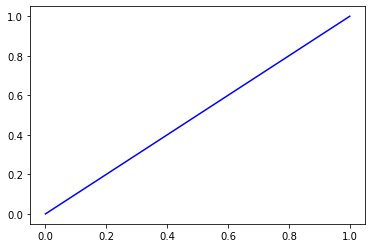

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.497545,0.496998,0.497589,0.498091,0.497253,0.5
Validation,0.501251,0.493536,0.501479,0.509016,0.496868,0.5



MultinomialNB
╠■■■■■■■■■╣


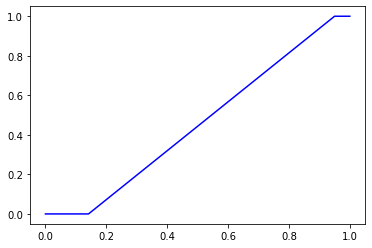

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.504773,0.083742,0.530077,0.925727,0.144616,0.516253
Validation,0.513505,0.082634,0.595712,0.945082,0.144499,0.527155



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0 ± 0.0000,smoker
0 ± 0.0000,autoimmune_dis
0 ± 0.0000,asthma
0 ± 0.0000,cancer
0 ± 0.0000,htn
0 ± 0.0000,chd
0 ± 0.0000,diabetes


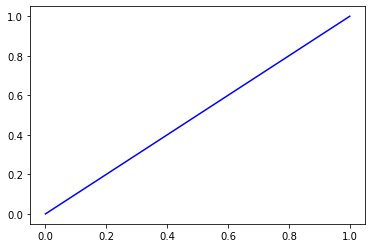

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500682,0.606727,0.402475,0.394636,0.423195,0.502085
Validation,0.496721,0.608197,0.367052,0.385246,0.418862,0.490231



XGBoost Classifier
╠■■■■■■■■■╣


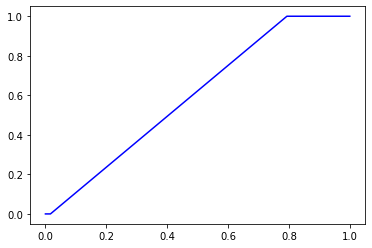

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.514501,0.729910,0.522090,0.299091,0.550172,0.523303
Validation,0.508603,0.727023,0.498708,0.290164,0.548872,0.510208



SVM
╠■■■■■■■■■╣


Weight?,Feature
+0.833,<BIAS>
+0.167,cancer
+0.167,htn
+0.167,diabetes
-1.833,autoimmune_dis
-1.833,smoker
-1.834,asthma


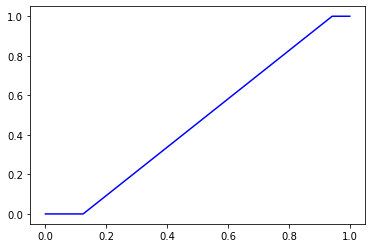

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.512638,0.834802,0.528737,0.190545,0.594181,0.495131
Validation,0.503685,0.822291,0.485787,0.184426,0.584999,0.488617



KNN
╠■■■■■■■■■╣


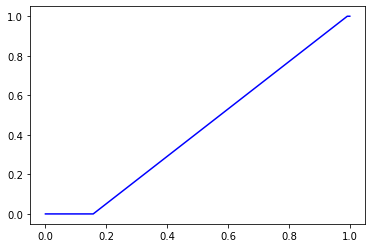

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.508728,0.031372,0.722635,0.986000,0.059404,0.499156
Validation,0.500415,0.022891,0.548929,0.978689,0.043295,0.493914



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.027,diabetes
+0.503,cancer
+0.195,htn
+0.054,smoker
+0.003,<BIAS>
-0.153,chd
-0.270,autoimmune_dis
-0.658,asthma


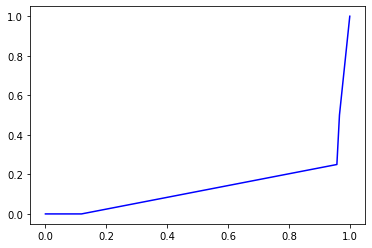

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.512501,0.720338,0.519091,0.304727,0.543370,0.518807
Validation,0.503675,0.699380,0.470653,0.307377,0.523367,0.507897


In [174]:
run_models(comorb, y[comorb.index], models, ratio_negatives_to_positives = 1)

Dummy Random
╠■■■■■■■■■╣


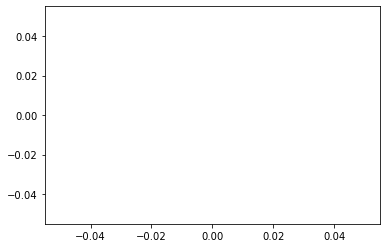

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.499136,0.499453,0.499081,0.498818,0.499256,0.5
Validation,0.491373,0.488451,0.491690,0.494262,0.489694,0.5



MultinomialNB
╠■■■■■■■■■╣


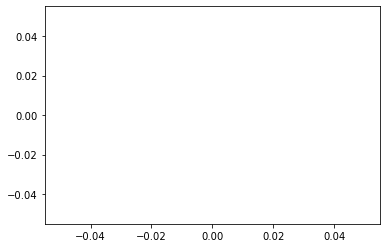

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.528457,0.198945,0.584308,0.857909,0.296026,0.559193
Validation,0.524130,0.201126,0.558514,0.847541,0.292318,0.547276



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.5217 ± 0.8542,high_risk_exposure_occupation
0.4783 ± 0.8285,high_risk_interactions
0 ± 0.0000,autoimmune_dis
0 ± 0.0000,asthma
0 ± 0.0000,cancer
0 ± 0.0000,htn
0 ± 0.0000,chd
0 ± 0.0000,diabetes


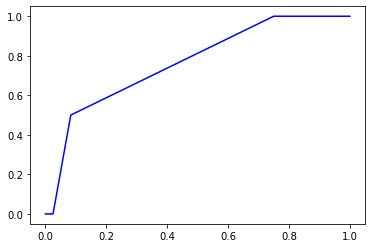

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.532821,0.665248,0.541275,0.400455,0.538622,0.549897
Validation,0.517631,0.637218,0.530892,0.397541,0.516479,0.538027



XGBoost Classifier
╠■■■■■■■■■╣


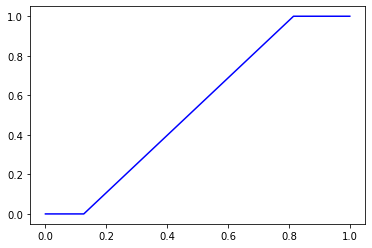

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.548050,0.727876,0.546330,0.368273,0.591476,0.570859
Validation,0.509018,0.677442,0.491119,0.340164,0.546920,0.526580



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.000,autoimmune_dis
+0.667,chd
+0.666,diabetes
+0.666,htn
+0.666,high_risk_exposure_occupation
+0.334,<BIAS>
-0.167,cancer
-1.167,asthma
-1.334,high_risk_interactions


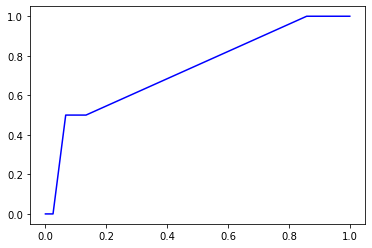

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.532411,0.386786,0.579139,0.678091,0.396386,0.548605
Validation,0.507784,0.346315,0.508096,0.668852,0.348288,0.515598



KNN
╠■■■■■■■■■╣


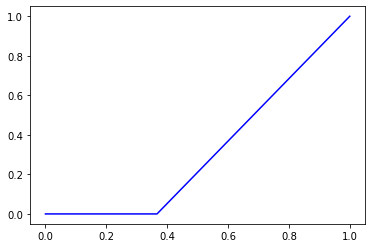

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.518184,0.069835,0.695718,0.966455,0.124633,0.548389
Validation,0.506956,0.060489,0.546851,0.954098,0.104520,0.541736



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+0.561,diabetes
+0.500,chd
+0.435,high_risk_exposure_occupation
+0.294,htn
+0.003,cancer
-0.018,<BIAS>
-0.264,high_risk_interactions
-0.461,autoimmune_dis
-0.946,asthma


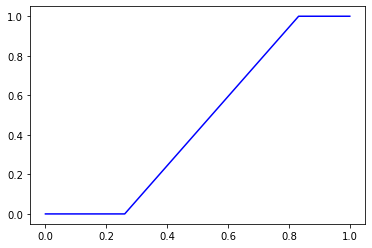

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.542277,0.658698,0.553933,0.425909,0.549825,0.563473
Validation,0.528657,0.630581,0.522793,0.426230,0.521671,0.546269


In [131]:
comorb_ef = pd.concat([comorb.drop(columns="smoker"), e_factors.drop(columns="age")], axis=1)
run_models(comorb_ef, y[comorb_ef.index], models, ratio_negatives_to_positives = 1)

We definetley need another set, even though using the cross validation for data imbalancing helped a lot

### Vitals

$ PAM = DIA + \frac{SIS-DIA}{3}$<br>
where PAM = Presión arterial media
SIS = Sístole
DIA = Diástole

In [132]:
def calculate_pam(data_x):
    return vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)

In [133]:
pam = vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)
vitals = pd.concat([vitals, pam], axis=1)
vitals.rename({ 0 : "pam"}, axis=1,inplace =True) #To rename the column that was appended (which has a value of 0 that is not a string)
i = vitals[vitals.iloc[:,-1] >145].iloc[:,-1].index
pd.concat([vitals.loc[i, ["sys", "dia"]], e_factors.loc[i,"age"]], axis=1)

KeyError: 'dia'

As expected, all pressure variables (including pam) are correlated between each other

In [139]:
#Drop all values that are Nan
vitals.dropna(how="all",inplace=True)
vitals.drop(columns=["sys", "dia"], inplace=True) #Because we have 'pam' we don't need it anymore (I ran some experiments and it is sligthly better with 'pam')
vitals.info()

KeyError: "['sys' 'dia'] not found in axis"

<AxesSubplot:>

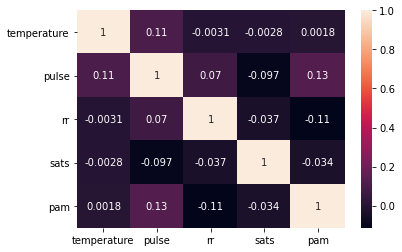

In [175]:
sns.heatmap(vitals.corr(), annot=True)

In [176]:
s_vitals = vitals.copy()
s_vitals = s_vitals.apply(lambda x: (x - x.mean()) / x.std())
n_vitals = vitals.copy()
n_vitals = s_vitals.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Dummy Random
╠■■■■■■■■■╣


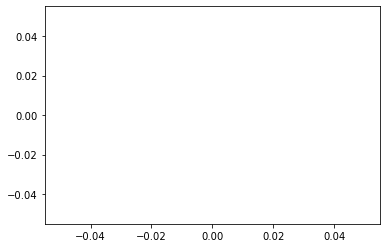

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.503916,0.502779,0.503646,0.505051,0.503139,0.5
Validation,0.481484,0.490375,0.483225,0.472477,0.486263,0.5



MultinomialNB
╠■■■■■■■■■╣


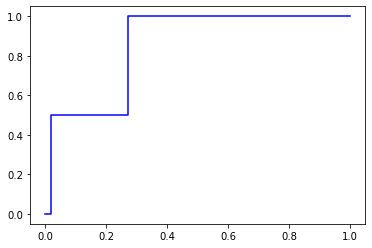

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.565358,0.532707,0.569702,0.59798,0.550567,0.597863
Validation,0.550499,0.533244,0.553594,0.56789,0.541896,0.575651



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.4507 ± 0.6198,temperature
0.3872 ± 0.6033,pulse
0.1066 ± 0.3655,pam
0.0312 ± 0.1169,rr
0.0243 ± 0.1568,sats


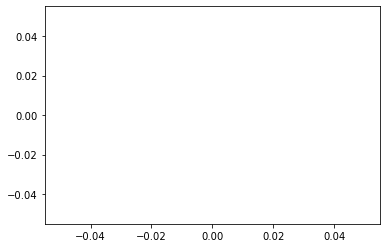

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.616240,0.577088,0.626279,0.655354,0.600376,0.663710
Validation,0.588871,0.550559,0.594709,0.627523,0.568996,0.621308



XGBoost Classifier
╠■■■■■■■■■╣


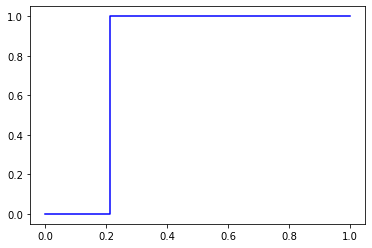

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.998181,0.997574,0.998786,0.998788,0.998179,0.999984
Validation,0.528109,0.508657,0.531248,0.547706,0.519242,0.558035



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.351,temperature
+0.122,rr
+0.027,pulse
+0.007,pam
-0.033,sats
-51.254,<BIAS>


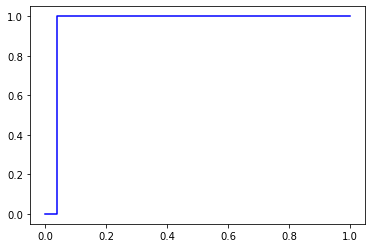

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.597292,0.509152,0.617851,0.685354,0.558087,0.641559
Validation,0.601661,0.511435,0.623904,0.692661,0.557935,0.642954



KNN
╠■■■■■■■■■╣


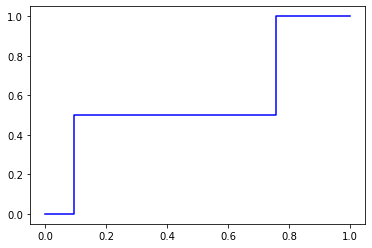

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.998535,0.997068,1.000000,1.000000,0.998531,0.999994
Validation,0.567389,0.572377,0.567046,0.562385,0.568422,0.612552



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.009,temperature
+0.062,rr
+0.025,pulse
+0.009,pam
-0.097,sats
-31.374,<BIAS>


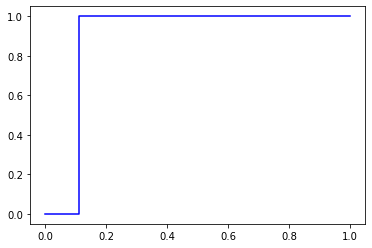

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.589056,0.557376,0.594817,0.620707,0.575458,0.632071
Validation,0.597545,0.550575,0.607370,0.644954,0.575496,0.639974


In [177]:
run_models(vitals, y[vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


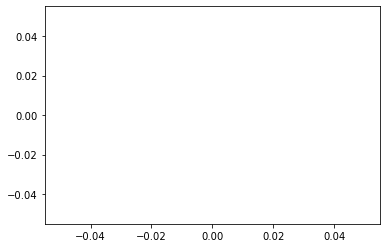

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.503006,0.502680,0.502746,0.503333,0.502659,0.5
Validation,0.498416,0.494996,0.500653,0.501835,0.497395,0.5



MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.4676 ± 0.6372,pulse
0.3455 ± 0.6079,temperature
0.0930 ± 0.2580,pam
0.0655 ± 0.1963,rr
0.0283 ± 0.1723,sats


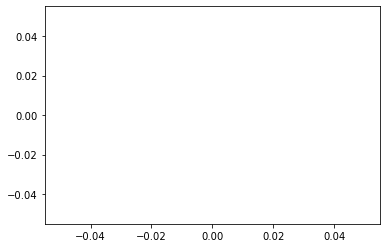

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.611945,0.576284,0.620491,0.647576,0.597297,0.663491
Validation,0.598934,0.554195,0.608177,0.644037,0.576569,0.639872



XGBoost Classifier
╠■■■■■■■■■╣


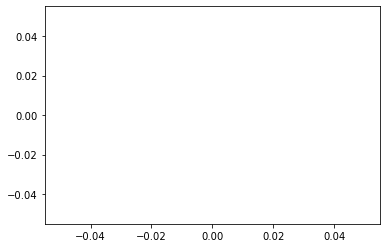

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.997878,0.998180,0.997576,0.997576,0.997878,0.999974
Validation,0.533576,0.531384,0.535002,0.535780,0.532686,0.554519



SVM
╠■■■■■■■■■╣


Weight?,Feature
+0.484,temperature
+0.388,pulse
+0.179,pam
+0.142,rr
-0.007,sats
-0.312,<BIAS>


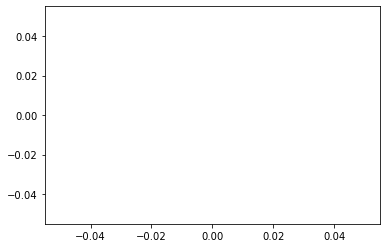

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.593149,0.508545,0.611900,0.677677,0.555378,0.638460
Validation,0.590233,0.501435,0.606831,0.679817,0.546460,0.629358



KNN
╠■■■■■■■■■╣


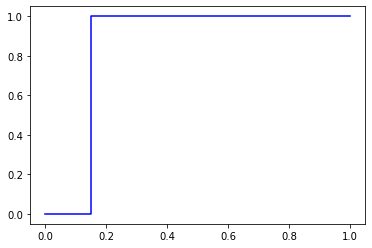

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.998535,0.997270,0.999797,0.999798,0.998532,0.999994
Validation,0.582475,0.494996,0.598255,0.670642,0.540593,0.631209



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+0.363,temperature
+0.237,pulse
+0.072,rr
-0.010,pam
-0.119,<BIAS>
-0.126,sats


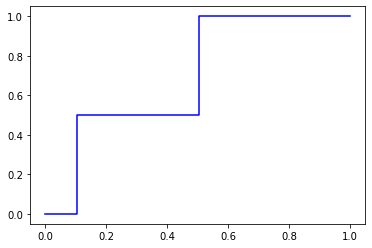

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.592593,0.558893,0.599045,0.626263,0.578264,0.637494
Validation,0.601200,0.556047,0.612164,0.646789,0.579148,0.640484


In [178]:
run_models(s_vitals, y[s_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


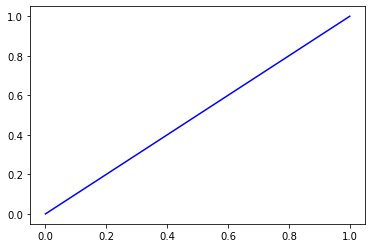

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.498559,0.498534,0.498356,0.498586,0.498366,0.5
Validation,0.507972,0.525880,0.510308,0.489908,0.517769,0.5



MultinomialNB
╠■■■■■■■■■╣


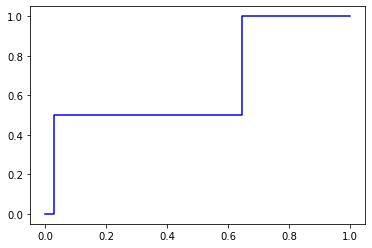

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.574604,0.539682,0.580009,0.609495,0.559103,0.608897
Validation,0.562362,0.525972,0.566362,0.599083,0.543874,0.604252



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3491 ± 0.5581,pulse
0.3392 ± 0.5754,temperature
0.2518 ± 0.4922,pam
0.0303 ± 0.1363,rr
0.0296 ± 0.1402,sats


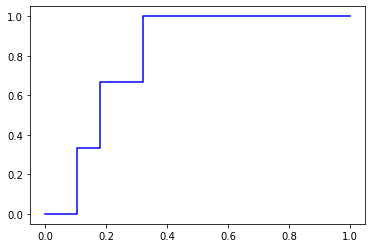

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.612248,0.584978,0.618819,0.639495,0.601245,0.665026
Validation,0.578807,0.557832,0.581600,0.600000,0.566437,0.622202



XGBoost Classifier
╠■■■■■■■■■╣


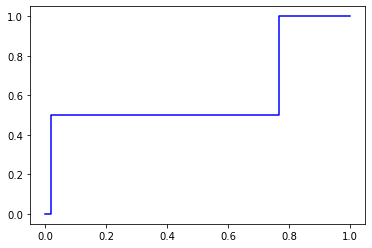

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.998181,0.998483,0.997880,0.997879,0.998180,0.999987
Validation,0.552319,0.533253,0.557864,0.571560,0.543779,0.579137



SVM
╠■■■■■■■■■╣


Weight?,Feature
+5.163,temperature
+3.285,pulse
+1.989,pam
+1.294,rr
+0.031,sats
-4.815,<BIAS>


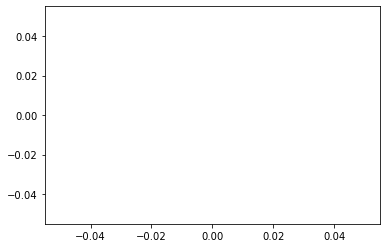

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.589056,0.489536,0.610865,0.688485,0.543458,0.631355
Validation,0.572875,0.476881,0.587016,0.669725,0.524501,0.623661



KNN
╠■■■■■■■■■╣


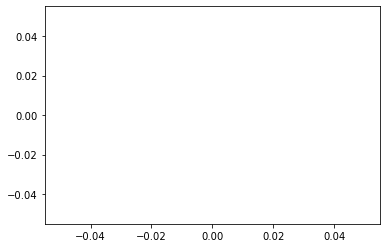

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.998636,0.997371,0.999899,0.999899,0.998632,0.999994
Validation,0.548659,0.516847,0.552142,0.580734,0.530596,0.589101



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+3.087,pulse
+2.290,temperature
+1.755,rr
+0.270,sats
+0.255,pam
-3.036,<BIAS>


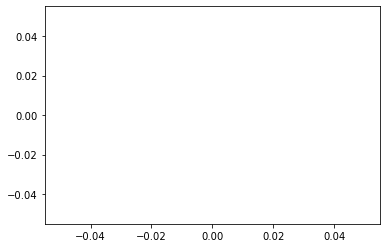

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.588550,0.551006,0.595513,0.626061,0.572392,0.635910
Validation,0.592971,0.548749,0.601944,0.637615,0.570986,0.637298


In [179]:
run_models(n_vitals, y[n_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


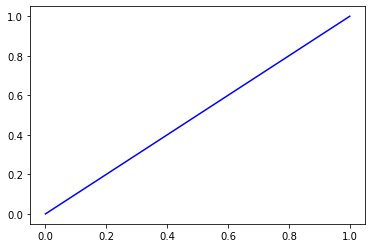

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.503057,0.500556,0.502814,0.505556,0.501625,0.5
Validation,0.502051,0.493203,0.503869,0.511009,0.497954,0.5



MultinomialNB
╠■■■■■■■■■╣


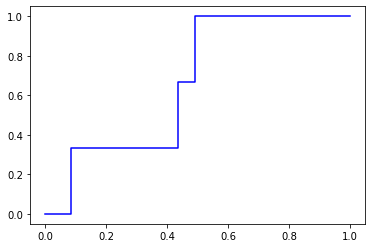

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.561871,0.514911,0.570795,0.608788,0.536438,0.587662
Validation,0.553209,0.479491,0.567136,0.627523,0.514242,0.583052



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.4036 ± 0.7178,temperature
0.1751 ± 0.5130,pulse
0.1388 ± 0.4365,pam
0.1106 ± 0.3948,sats
0.0824 ± 0.2826,age
0.0635 ± 0.2783,rr
0.0260 ± 0.1396,high_risk_interactions
0 ± 0.0000,high_risk_exposure_occupation


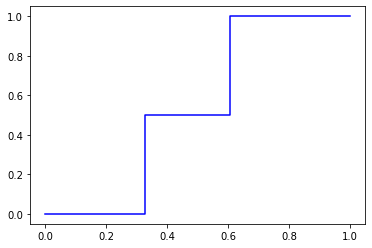

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.623971,0.598625,0.631139,0.649293,0.613503,0.676680
Validation,0.598460,0.556922,0.606283,0.640367,0.578012,0.637609



XGBoost Classifier
╠■■■■■■■■■╣


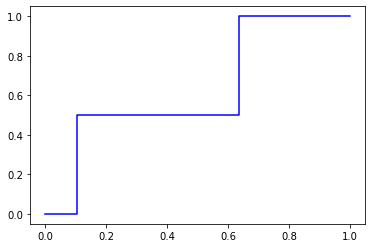

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999545,0.999393,0.999697,0.999697,0.999545,0.999999
Validation,0.544527,0.548649,0.545235,0.540367,0.546117,0.573223



SVM
╠■■■■■■■■■╣


Weight?,Feature
+4.831,temperature
+3.341,pulse
+1.051,pam
+0.788,high_risk_exposure_occupation
+0.110,sats
-0.044,age
-0.364,rr
-0.570,high_risk_interactions
-3.846,<BIAS>


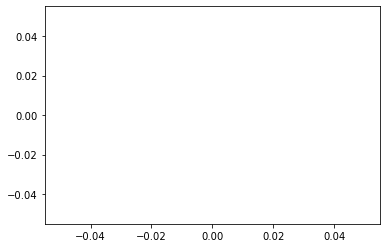

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.599617,0.530383,0.615695,0.668788,0.56971,0.646406
Validation,0.582944,0.504145,0.598194,0.662385,0.54409,0.622360



KNN
╠■■■■■■■■■╣


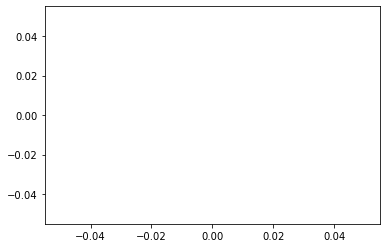

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999646,0.999292,1.000000,1.000000,0.999646,0.999999
Validation,0.558686,0.506797,0.566895,0.611009,0.533327,0.594007



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+3.554,temperature
+2.593,pulse
+1.866,pam
+1.217,rr
+0.416,high_risk_exposure_occupation
+0.059,age
-0.392,sats
-0.416,high_risk_interactions
-3.385,<BIAS>


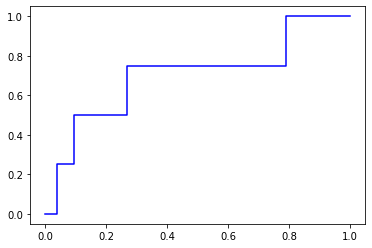

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.603002,0.569407,0.610289,0.636566,0.589096,0.649568
Validation,0.590675,0.562360,0.594715,0.619266,0.575134,0.630604


In [180]:
n_vitals_ex = pd.merge(n_vitals, e_factors, left_index=True, right_index=True)
run_models(n_vitals_ex, y[n_vitals_ex.index], models, ratio_negatives_to_positives=1)

### Assesed Symptoms

In [181]:
a_symptoms.dropna(how="all", inplace=True)

Dummy Random
╠■■■■■■■■■╣


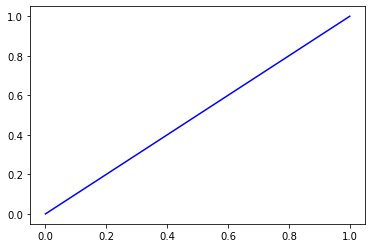

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.492573,0.493154,0.492559,0.491993,0.492841,0.5
Validation,0.510671,0.503754,0.512279,0.517647,0.507319,0.5



MultinomialNB
╠■■■■■■■■■╣


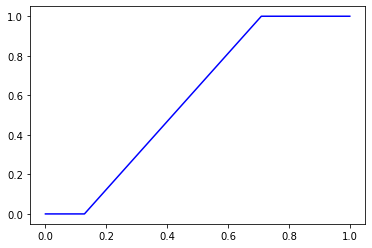

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.543884,0.848373,0.527253,0.239479,0.650324,0.547261
Validation,0.534165,0.841429,0.520986,0.226050,0.643258,0.536558



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.6105 ± 0.9337,days_since_symptom_onset
0.2161 ± 0.7184,ctab
0.1733 ± 0.7117,wheezes
0 ± 0.0000,rhonchi
0 ± 0.0000,labored_respiration


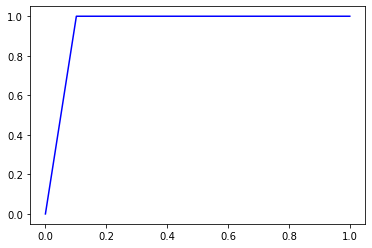

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.58849,0.397318,0.643287,0.779609,0.491140,0.612837
Validation,0.58665,0.392311,0.638914,0.781513,0.484701,0.610515



XGBoost Classifier
╠■■■■■■■■■╣


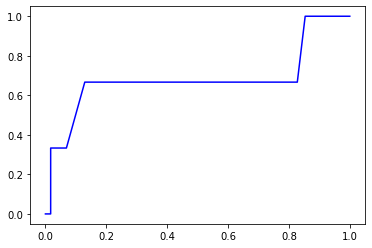

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.602971,0.403373,0.671836,0.802514,0.503815,0.639000
Validation,0.584139,0.371415,0.648052,0.797479,0.470410,0.602358



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.010,<BIAS>
+0.004,labored_respiration
+0.000,ctab
-0.004,days_since_symptom_onset
-0.652,rhonchi
-1.344,wheezes


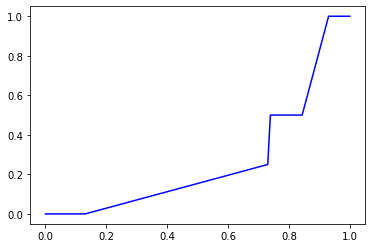

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.534758,0.880410,0.520549,0.189199,0.654203,0.534399
Validation,0.520725,0.867409,0.512108,0.173109,0.643832,0.501907



KNN
╠■■■■■■■■■╣


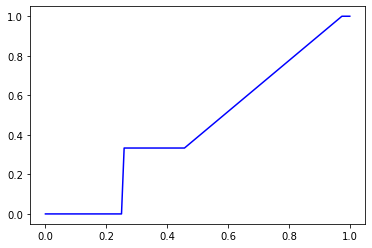

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.599154,0.371062,0.683763,0.827188,0.478966,0.595766
Validation,0.575737,0.342801,0.636987,0.809244,0.441217,0.560090



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.015,labored_respiration
+0.220,wheezes
+0.064,<BIAS>
+0.008,days_since_symptom_onset
-0.388,rhonchi
-0.513,ctab


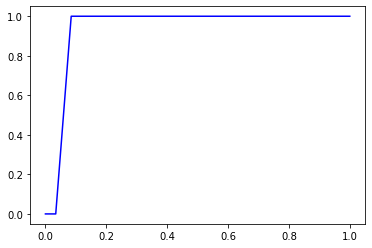

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.548587,0.830677,0.531038,0.266574,0.647868,0.54912
Validation,0.553933,0.829769,0.535189,0.277311,0.650473,0.55144


In [182]:
run_models(a_symptoms, y[a_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


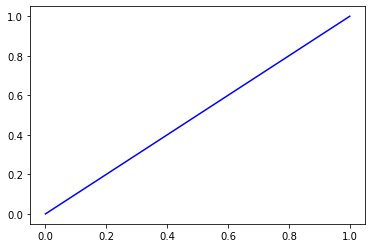

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.503515,0.505820,0.503341,0.501210,0.504525,0.5
Validation,0.511951,0.506232,0.512405,0.517647,0.509043,0.5



MultinomialNB
╠■■■■■■■■■╣


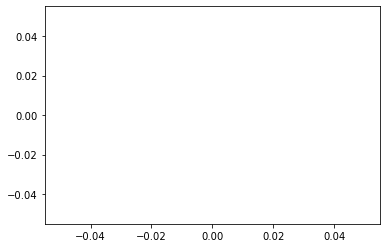

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.550122,0.694698,0.538761,0.405587,0.604679,0.565454
Validation,0.545934,0.673873,0.537476,0.417647,0.595205,0.564209



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.2869 ± 0.7851,days_since_symptom_onset
0.2131 ± 0.6412,age
0.1918 ± 0.6660,wheezes
0.1743 ± 0.6448,ctab
0.1339 ± 0.5132,high_risk_interactions
0 ± 0.0000,high_risk_exposure_occupation
0 ± 0.0000,rhonchi
0 ± 0.0000,labored_respiration


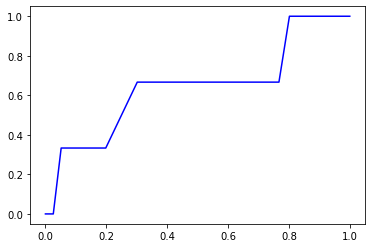

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.597105,0.524624,0.617322,0.669553,0.563219,0.636677
Validation,0.581205,0.492990,0.601814,0.669748,0.536663,0.618084



XGBoost Classifier
╠■■■■■■■■■╣


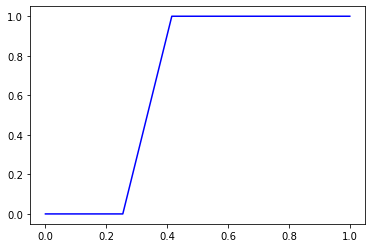

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.648461,0.587969,0.673738,0.708939,0.623381,0.726218
Validation,0.556825,0.504503,0.568045,0.609244,0.530209,0.572059



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.999,high_risk_exposure_occupation
+1.000,labored_respiration
-0.000,age
-0.000,days_since_symptom_onset
-0.000,ctab
-0.001,high_risk_interactions
-0.001,wheezes
-0.999,<BIAS>


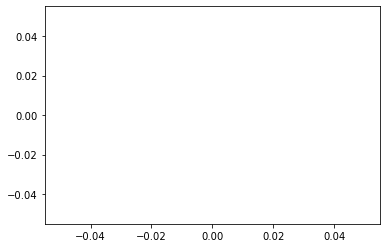

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.550869,0.716317,0.548508,0.385475,0.599046,0.571653
Validation,0.540913,0.698172,0.525585,0.383193,0.583284,0.545821



KNN
╠■■■■■■■■■╣


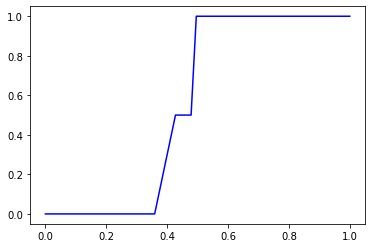

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.643665,0.435407,0.747364,0.851862,0.549453,0.683490
Validation,0.569876,0.367143,0.618835,0.773109,0.460003,0.572328



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+0.865,labored_respiration
+0.745,high_risk_exposure_occupation
+0.381,<BIAS>
+0.308,wheezes
-0.018,days_since_symptom_onset
-0.091,age
-0.377,rhonchi
-0.585,high_risk_interactions
-0.619,ctab


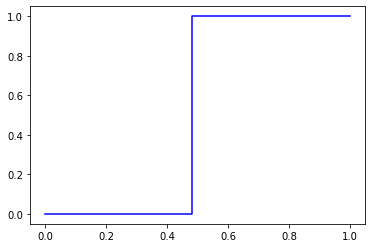

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.562368,0.716486,0.547746,0.408287,0.619951,0.584711
Validation,0.557669,0.698263,0.546504,0.416807,0.612194,0.565586


In [183]:
a_symptoms_ef = pd.merge(a_symptoms, e_factors, left_index=True, right_index=True)
run_models(a_symptoms_ef, y[a_symptoms_ef.index], models, ratio_negatives_to_positives=1)

### Reported symptoms

In [149]:
r_symptoms

,cough,cough_severity,fever,sob,sob_severity,diarrhea,fatigue,headache,loss_of_smell,loss_of_taste,runny_nose,muscle_sore,sore_throat
0,True,3.0,NaN,False,0.0,False,False,False,False,False,False,False,False
1,True,1.0,False,False,0.0,False,False,False,False,False,False,False,False
2,False,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,True,2.0,False,True,2.0,False,True,False,False,False,False,False,True
4,True,1.0,False,False,0.0,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93989,False,0.0,False,False,0.0,False,False,False,False,False,False,False,False
93990,True,2.0,False,False,0.0,False,False,False,False,False,True,False,True
93991,False,0.0,True,False,0.0,False,False,False,False,False,False,False,False
93993,False,0.0,False,False,0.0,False,False,False,False,False,False,False,False


In [150]:
r_symptoms.dropna(how="all", inplace=True)

Dummy Random
╠■■■■■■■■■╣


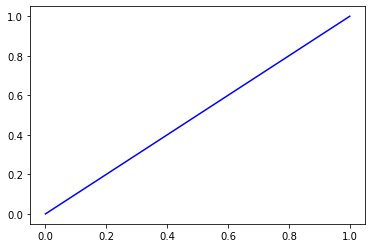

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.501410,0.496817,0.501433,0.506000,0.499044,0.5
Validation,0.493866,0.491843,0.493928,0.495902,0.492614,0.5



MultinomialNB
╠■■■■■■■■■╣


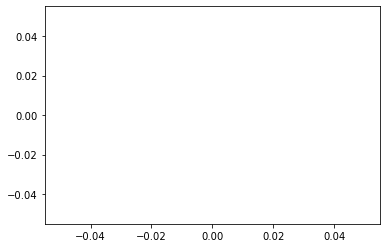

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.626284,0.356611,0.774118,0.895909,0.487798,0.603768
Validation,0.619563,0.349340,0.757434,0.890164,0.475122,0.600654



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3423 ± 0.8822,cough_severity
0.3342 ± 0.8807,cough
0.1480 ± 0.6476,headache
0.1406 ± 0.5978,fever
0.0269 ± 0.2806,fatigue
0.0081 ± 0.0756,sore_throat
0 ± 0.0000,muscle_sore
0 ± 0.0000,runny_nose
0 ± 0.0000,loss_of_taste
0 ± 0.0000,loss_of_smell


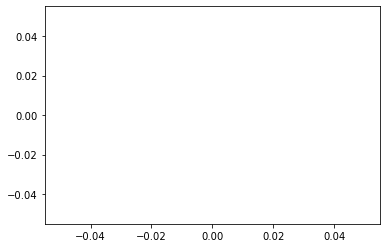

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.637057,0.435532,0.729488,0.838545,0.545242,0.668278
Validation,0.638386,0.431201,0.730813,0.845902,0.540154,0.668124



XGBoost Classifier
╠■■■■■■■■■╣


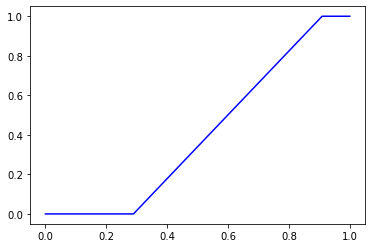

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.704155,0.499908,0.845415,0.908364,0.628023,0.753403
Validation,0.641653,0.436879,0.737706,0.846721,0.545780,0.654680



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.000,loss_of_smell
+1.995,cough
+1.092,muscle_sore
+1.090,loss_of_taste
+0.182,sob
+0.003,runny_nose
+0.002,fever
+0.002,cough_severity
+0.001,headache
-0.000,sore_throat


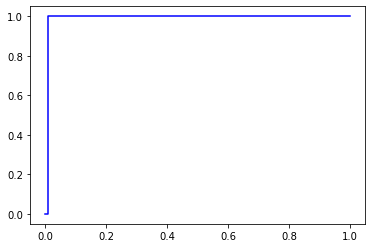

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.657059,0.464812,0.755663,0.849273,0.575062,0.686886
Validation,0.645355,0.458163,0.729609,0.832787,0.558680,0.678913



KNN
╠■■■■■■■■■╣


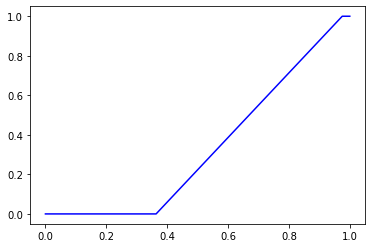

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.702745,0.482359,0.862740,0.923091,0.618577,0.738194
Validation,0.644122,0.437718,0.742947,0.850820,0.547942,0.650515



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.885,loss_of_taste
+1.249,loss_of_smell
+1.068,cough
+0.975,sob
+0.789,muscle_sore
+0.334,headache
+0.284,fever
+0.237,diarrhea
-0.099,cough_severity
-0.212,runny_nose


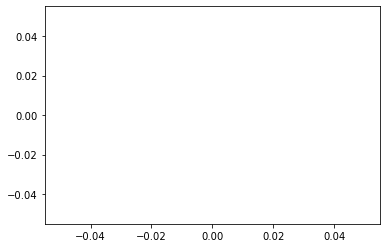

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.664014,0.484361,0.756136,0.843636,0.590391,0.688723
Validation,0.657650,0.481088,0.741423,0.834426,0.579925,0.681780


In [151]:
run_models(r_symptoms, y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


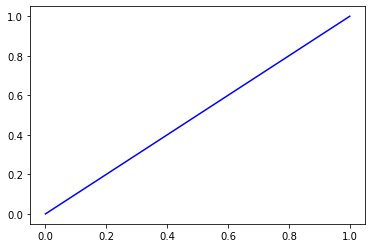

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.496227,0.500271,0.496249,0.492182,0.498189,0.5
Validation,0.499583,0.505671,0.500023,0.493443,0.502570,0.5



MultinomialNB
╠■■■■■■■■■╣


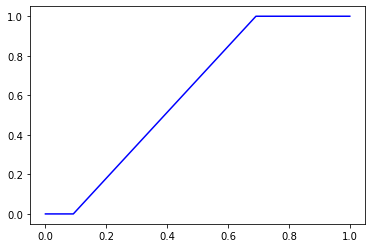

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.621056,0.337240,0.779934,0.904818,0.470239,0.599238
Validation,0.614215,0.332107,0.757150,0.896721,0.459138,0.586838



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.4872 ± 0.9513,cough_severity
0.2136 ± 0.7476,headache
0.1609 ± 0.6465,fever
0.0691 ± 0.4746,fatigue
0.0582 ± 0.4027,sore_throat
0.0111 ± 0.1990,muscle_sore
0 ± 0.0000,runny_nose
0 ± 0.0000,loss_of_taste
0 ± 0.0000,loss_of_smell
0 ± 0.0000,diarrhea


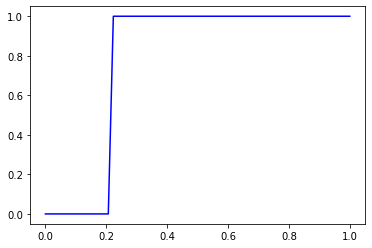

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.636421,0.475356,0.701236,0.797455,0.566482,0.662970
Validation,0.642094,0.468899,0.714010,0.815574,0.562593,0.667624



XGBoost Classifier
╠■■■■■■■■■╣


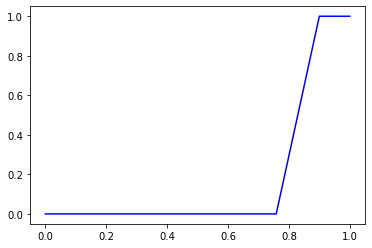

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.701836,0.505820,0.832060,0.897818,0.629034,0.755445
Validation,0.643712,0.443423,0.739962,0.844262,0.550495,0.652903



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.000,loss_of_smell
+1.001,headache
+1.000,loss_of_taste
+1.000,cough_severity
+0.999,muscle_sore
+0.000,fever
-0.000,sore_throat
-0.000,sob_severity
-0.000,fatigue
-0.000,diarrhea


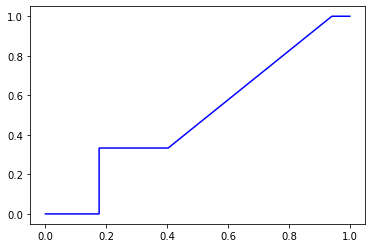

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.655378,0.452354,0.761803,0.858364,0.567420,0.683598
Validation,0.655592,0.443436,0.766107,0.868033,0.557744,0.678611



KNN
╠■■■■■■■■■╣


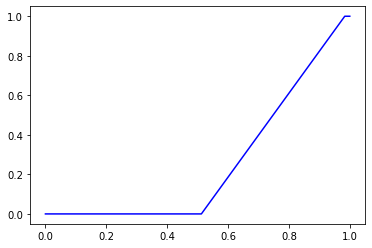

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.703382,0.495091,0.849058,0.911636,0.625150,0.736580
Validation,0.646183,0.441770,0.748092,0.850820,0.551954,0.649322



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.992,loss_of_smell
+1.308,loss_of_taste
+0.961,cough_severity
+0.586,muscle_sore
+0.551,headache
+0.419,fever
+0.200,runny_nose
-0.236,diarrhea
-0.397,sob_severity
-0.475,<BIAS>


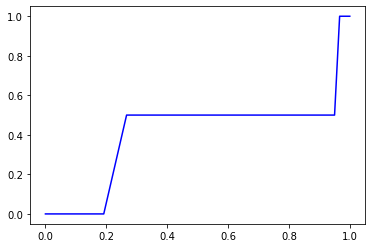

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.664969,0.482723,0.759592,0.847182,0.590210,0.691190
Validation,0.650259,0.468852,0.732407,0.831967,0.568792,0.680201


In [152]:
run_models(r_symptoms.drop(columns=["sob", "cough"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


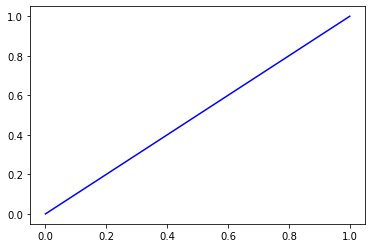

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.502409,0.504273,0.502352,0.500545,0.503289,0.5
Validation,0.511892,0.514807,0.511914,0.509016,0.513174,0.5



MultinomialNB
╠■■■■■■■■■╣


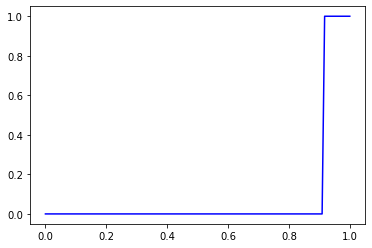

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.617692,0.327876,0.780011,0.907455,0.461507,0.593536
Validation,0.614224,0.320685,0.772604,0.908197,0.450405,0.587372



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.4788 ± 0.8895,cough
0.2945 ± 0.7679,fever
0.1317 ± 0.5418,headache
0.0906 ± 0.4761,fatigue
0.0044 ± 0.0669,sore_throat
0 ± 0.0000,muscle_sore
0 ± 0.0000,runny_nose
0 ± 0.0000,loss_of_taste
0 ± 0.0000,loss_of_smell
0 ± 0.0000,diarrhea


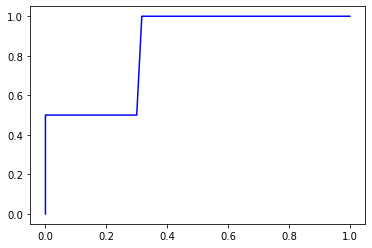

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.640512,0.473086,0.711436,0.807909,0.568146,0.672060
Validation,0.636783,0.472124,0.702598,0.801639,0.561010,0.662572



XGBoost Classifier
╠■■■■■■■■■╣


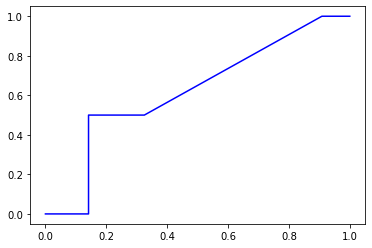

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.701291,0.506363,0.829971,0.896182,0.628783,0.750551
Validation,0.653531,0.456511,0.750027,0.850820,0.564246,0.656723



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.000,cough
+2.000,loss_of_smell
+1.999,muscle_sore
+0.002,loss_of_taste
+0.000,headache
+0.000,fever
-0.000,runny_nose
-0.000,sob
-0.000,fatigue
-0.000,sore_throat


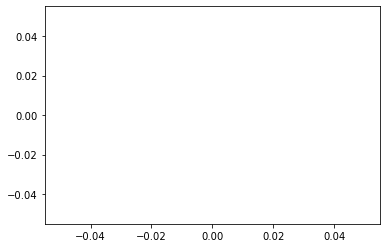

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.651287,0.447539,0.756282,0.855000,0.561447,0.684696
Validation,0.651480,0.442590,0.761073,0.860656,0.554501,0.689714



KNN
╠■■■■■■■■■╣


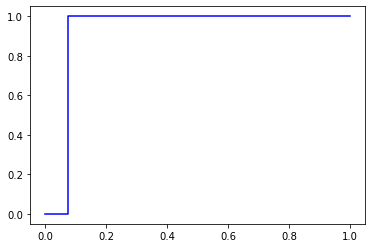

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.696200,0.488452,0.836131,0.903909,0.616274,0.732452
Validation,0.635948,0.427083,0.734634,0.845082,0.537419,0.660924



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+2.087,loss_of_smell
+1.037,cough
+0.902,muscle_sore
+0.663,loss_of_taste
+0.409,fever
+0.206,headache
+0.031,sore_throat
-0.087,sob
-0.087,runny_nose
-0.199,fatigue


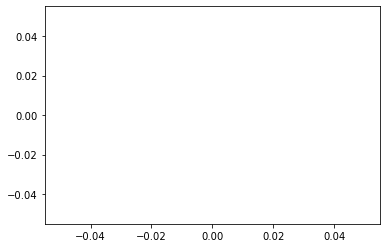

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.663151,0.485087,0.753471,0.841182,0.590089,0.692497
Validation,0.661301,0.478622,0.750703,0.844262,0.581322,0.679510


In [153]:
run_models(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


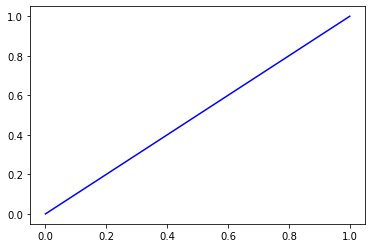

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.500676,0.499579,0.500687,0.501769,0.500088,0.5
Validation,0.504019,0.509720,0.504468,0.498319,0.506854,0.5



MultinomialNB
╠■■■■■■■■■╣


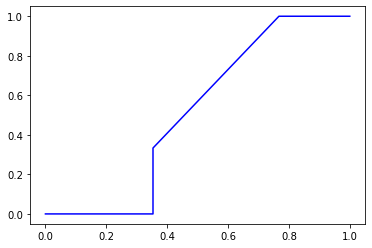

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.642874,0.498371,0.700846,0.787337,0.582493,0.680881
Validation,0.639534,0.495455,0.693352,0.784034,0.574919,0.674444



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3857 ± 0.9051,cough
0.2271 ± 0.7621,headache
0.1657 ± 0.7006,days_since_symptom_onset
0.1223 ± 0.5625,fever
0.0429 ± 0.2992,wheezes
0.0257 ± 0.2816,ctab
0.0164 ± 0.2134,sore_throat
0.0143 ± 0.2088,fatigue
0 ± 0.0000,rhonchi
0 ± 0.0000,labored_respiration


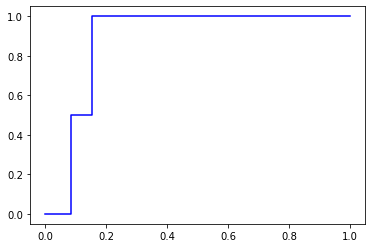

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.644085,0.506568,0.698694,0.781564,0.587268,0.684412
Validation,0.642896,0.500371,0.698678,0.785714,0.579659,0.689877



XGBoost Classifier
╠■■■■■■■■■╣


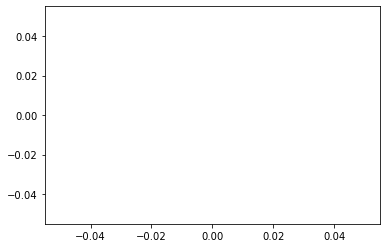

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.761606,0.585639,0.903609,0.937523,0.710609,0.837014
Validation,0.638299,0.463641,0.712228,0.813445,0.559180,0.650540



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.000,loss_of_smell
+2.000,cough
+0.001,labored_respiration
+0.000,headache
+0.000,muscle_sore
+0.000,loss_of_taste
+0.000,fever
-0.000,days_since_symptom_onset
-0.000,wheezes
-0.000,fatigue


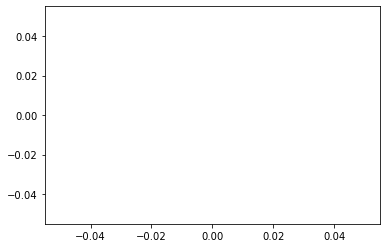

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.656470,0.449570,0.767189,0.863315,0.566172,0.701611
Validation,0.652959,0.440882,0.761192,0.865546,0.555543,0.694382



KNN
╠■■■■■■■■■╣


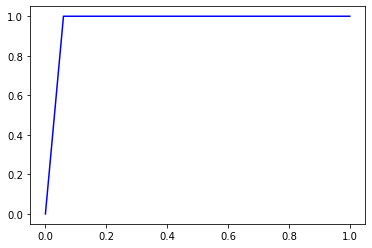

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.76128,0.565522,0.929410,0.956983,0.703073,0.806622
Validation,0.63326,0.457661,0.702726,0.809244,0.551690,0.641714



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+2.117,loss_of_smell
+1.244,cough
+1.035,loss_of_taste
+0.803,muscle_sore
+0.781,headache
+0.292,fever
+0.255,wheezes
+0.140,labored_respiration
+0.071,runny_nose
+0.022,sob


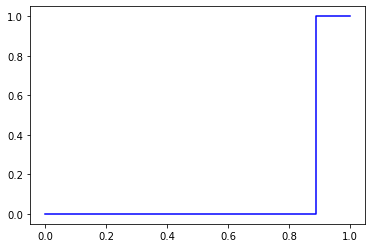

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.670717,0.505818,0.755189,0.835568,0.605399,0.710155
Validation,0.665128,0.495413,0.744052,0.835294,0.591974,0.702710


In [154]:
ra_symptoms = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), a_symptoms, left_index=True, right_index=True)
run_models(ra_symptoms, y[ra_symptoms.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


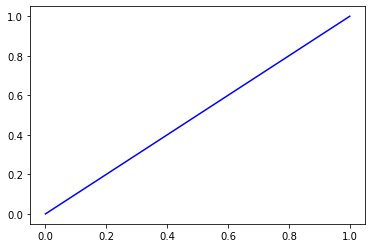

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.499545,0.494819,0.499549,0.504273,0.497085,0.5
Validation,0.496726,0.499194,0.497703,0.494262,0.498061,0.5



MultinomialNB
╠■■■■■■■■■╣


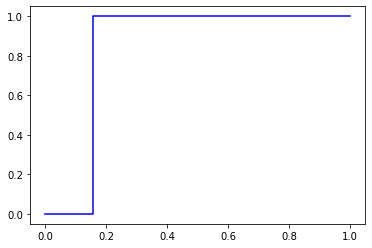

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.642285,0.468814,0.718147,0.815727,0.567195,0.677580
Validation,0.647431,0.470565,0.726099,0.824590,0.567574,0.673633



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.3440 ± 0.8871,cough_severity
0.1676 ± 0.6836,headache
0.1437 ± 0.5842,fever
0.0718 ± 0.4285,age
0.0684 ± 0.4302,fatigue
0.0648 ± 0.4263,high_risk_exposure_occupation
0.0542 ± 0.4157,sore_throat
0.0441 ± 0.3035,high_risk_interactions
0.0416 ± 0.3831,muscle_sore
0 ± 0.0000,runny_nose


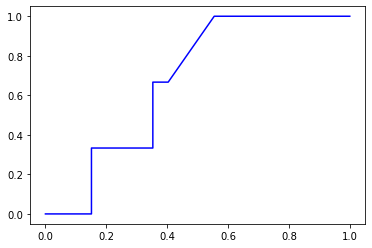

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.642331,0.478449,0.712110,0.806182,0.571904,0.683574
Validation,0.628172,0.470505,0.684133,0.786066,0.554849,0.664507



XGBoost Classifier
╠■■■■■■■■■╣


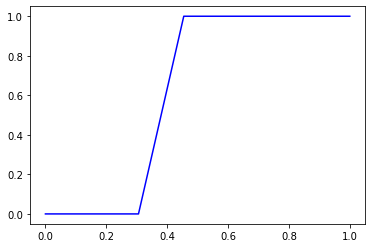

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.752659,0.577648,0.888848,0.927636,0.700136,0.835192
Validation,0.638382,0.468806,0.708471,0.808197,0.562695,0.654359



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.000,loss_of_smell
+1.251,loss_of_taste
+1.250,muscle_sore
+1.249,cough_severity
+0.749,headache
+0.001,fever
+0.000,runny_nose
+0.000,fatigue
+0.000,age
-0.000,high_risk_exposure_occupation


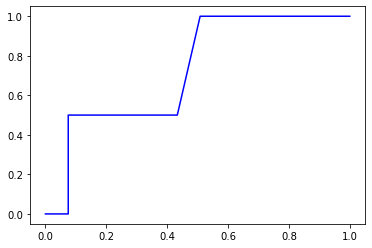

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.656878,0.454266,0.763795,0.859455,0.569539,0.698642
Validation,0.656002,0.441830,0.769127,0.870492,0.558616,0.695052



KNN
╠■■■■■■■■■╣


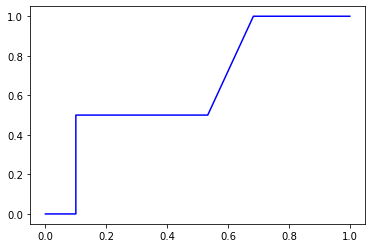

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.749432,0.537368,0.933367,0.961455,0.681893,0.809496
Validation,0.621624,0.385426,0.729147,0.858197,0.500603,0.634183



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.032,loss_of_smell
+1.009,loss_of_taste
+0.764,headache
+0.684,cough_severity
+0.438,muscle_sore
+0.421,high_risk_exposure_occupation
+0.286,fever
+0.087,age
+0.052,runny_nose
-0.262,sob_severity


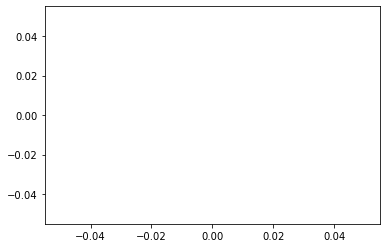

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.662015,0.499180,0.740798,0.824818,0.596205,0.703652
Validation,0.657233,0.485206,0.735016,0.829508,0.581375,0.688650


In [155]:
r_symptoms_ex = pd.merge(r_symptoms.drop(columns=["sob", "cough"]), e_factors, left_index=True, right_index=True)
run_models(r_symptoms_ex, y[r_symptoms_ex.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


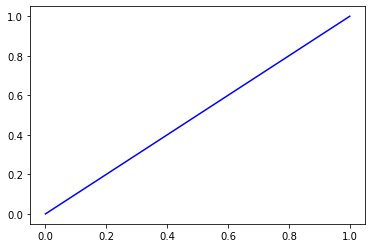

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.499318,0.499343,0.499087,0.499293,0.499195,0.5
Validation,0.507991,0.516847,0.510438,0.499083,0.513010,0.5



MultinomialNB
╠■■■■■■■■■╣


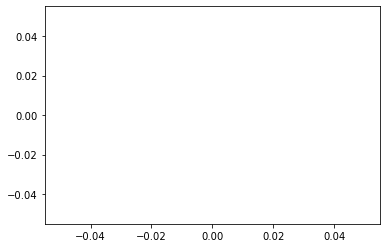

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.656865,0.516026,0.718157,0.797576,0.600464,0.703553
Validation,0.664233,0.511393,0.734503,0.818349,0.600378,0.712672



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.2631 ± 0.7444,cough
0.2197 ± 0.5332,pulse
0.2193 ± 0.5971,temperature
0.0818 ± 0.3037,rr
0.0785 ± 0.3368,pam
0.0551 ± 0.3775,headache
0.0487 ± 0.3153,sats
0.0270 ± 0.1835,fever
0.0068 ± 0.1321,fatigue
0 ± 0.0000,sore_throat


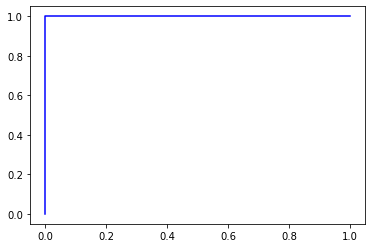

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.661513,0.564553,0.700263,0.758384,0.624954,0.720434
Validation,0.647799,0.556005,0.679246,0.740367,0.609754,0.687322



XGBoost Classifier
╠■■■■■■■■■╣


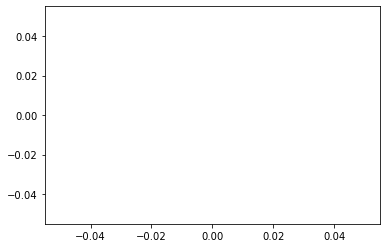

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999293,0.999191,0.999394,0.999394,0.999292,0.999998
Validation,0.607576,0.598716,0.612022,0.616514,0.604799,0.662493



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.946,cough
+1.938,loss_of_smell
+1.796,muscle_sore
+0.117,loss_of_taste
+0.072,temperature
+0.056,headache
+0.028,fever
+0.014,runny_nose
+0.005,rr
+0.001,pam


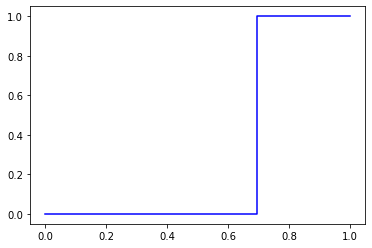

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.661412,0.456273,0.773576,0.866364,0.573505,0.735627
Validation,0.661045,0.444979,0.785331,0.878899,0.563443,0.730213



KNN
╠■■■■■■■■■╣


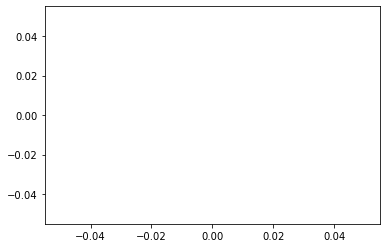

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999646,0.999292,1.000000,1.000000,0.999646,1.000000
Validation,0.555081,0.526939,0.562187,0.583486,0.541283,0.594754



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+2.032,loss_of_smell
+1.090,loss_of_taste
+0.970,cough
+0.684,muscle_sore
+0.452,fever
+0.413,headache
+0.258,temperature
+0.040,fatigue
+0.032,rr
+0.020,pulse


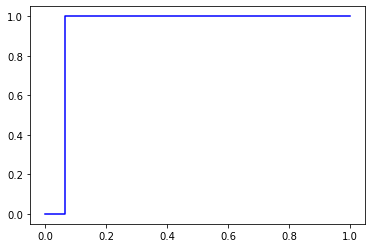

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.672275,0.547566,0.729389,0.796869,0.625472,0.729694
Validation,0.661036,0.529616,0.719739,0.793578,0.608558,0.719470


In [156]:
r_symptoms_vitals = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), vitals, left_index=True, right_index=True)
run_models(r_symptoms_vitals, y[r_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


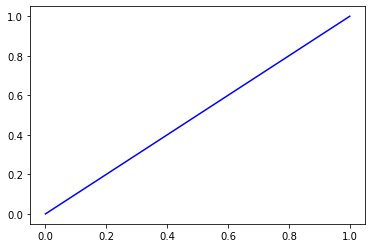

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.506164,0.503809,0.506089,0.508519,0.504910,0.5
Validation,0.507073,0.536906,0.507388,0.477064,0.521464,0.5



MultinomialNB
╠■■■■■■■■■╣


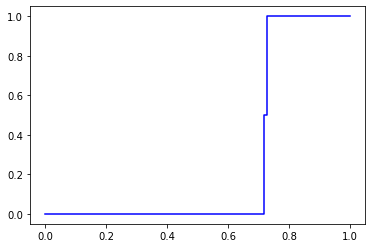

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.657722,0.526738,0.713751,0.788641,0.606085,0.709437
Validation,0.659021,0.515930,0.722610,0.802752,0.598771,0.716674



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.2613 ± 0.7868,cough
0.2442 ± 0.6706,temperature
0.2108 ± 0.6521,pulse
0.0990 ± 0.5179,headache
0.0615 ± 0.3193,pam
0.0339 ± 0.2692,fever
0.0209 ± 0.2110,rr
0.0175 ± 0.1194,sats
0.0161 ± 0.2228,fatigue
0.0158 ± 0.1807,days_since_symptom_onset


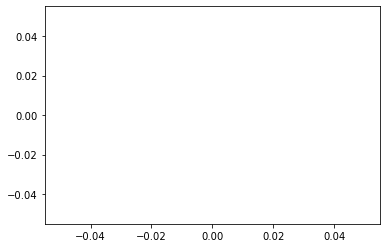

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.664671,0.583765,0.696946,0.745538,0.634886,0.72857
Validation,0.659474,0.571560,0.691478,0.747706,0.624004,0.71183



XGBoost Classifier
╠■■■■■■■■■╣


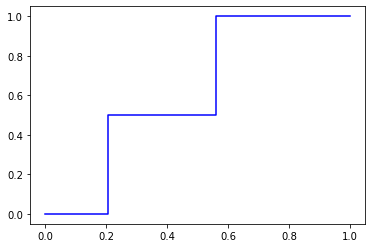

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999797,0.999594,1.00000,1.000000,0.999797,1.000000
Validation,0.612337,0.600876,0.61564,0.623853,0.607634,0.673072



SVM
╠■■■■■■■■■╣


Weight?,Feature
+1.992,loss_of_smell
+1.942,cough
+1.881,muscle_sore
+0.090,loss_of_taste
+0.065,temperature
+0.053,labored_respiration
+0.034,headache
+0.029,diarrhea
+0.022,runny_nose
+0.017,sore_throat


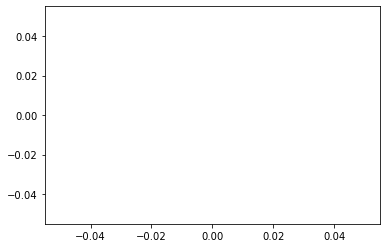

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.672636,0.473061,0.787104,0.872110,0.590883,0.744772
Validation,0.659926,0.461109,0.763916,0.859633,0.571005,0.727560



KNN
╠■■■■■■■■■╣


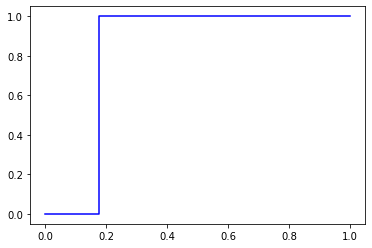

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.999746,0.999493,1.000000,1.00000,0.999746,1.000000
Validation,0.569306,0.499408,0.580699,0.63945,0.535334,0.617285



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.475,loss_of_smell
+1.345,cough
+0.983,muscle_sore
+0.869,loss_of_taste
+0.711,headache
+0.303,fever
+0.196,labored_respiration
+0.103,sore_throat
+0.066,rhonchi
+0.042,rr


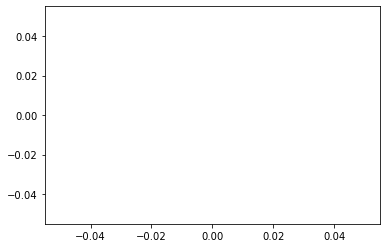

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.678062,0.560831,0.732445,0.795233,0.635236,0.736093
Validation,0.668200,0.546997,0.726079,0.789908,0.619038,0.720439


In [157]:
ra_symptoms_vitals = pd.merge(ra_symptoms, vitals, left_index=True, right_index=True)
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


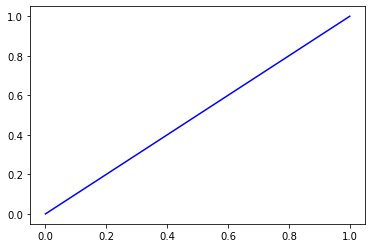

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.494135,0.495542,0.494042,0.492727,0.494779,0.5
Validation,0.501631,0.481947,0.501893,0.521311,0.491270,0.5



MultinomialNB
╠■■■■■■■■■╣


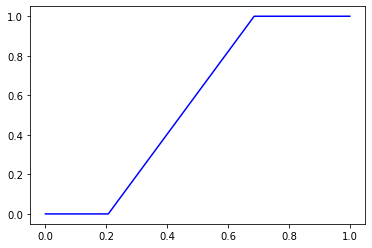

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.640649,0.411168,0.760056,0.870091,0.533512,0.644501
Validation,0.636751,0.411529,0.748922,0.862295,0.527171,0.640018



Random Forest (100 estimators)
╠■■■■■■■■■╣


Weight,Feature
0.4150 ± 0.9101,cough
0.1934 ± 0.6896,headache
0.1556 ± 0.5901,fever
0.1123 ± 0.5456,muscle_sore
0.0665 ± 0.4359,fatigue
0.0572 ± 0.3634,sore_throat
0 ± 0.0000,loss_of_taste
0 ± 0.0000,sob
0 ± 0.0000,diarrhea
0 ± 0.0000,loss_of_smell


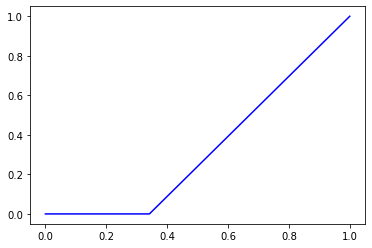

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.641149,0.478088,0.709848,0.804182,0.571161,0.668280
Validation,0.631858,0.472124,0.691366,0.791803,0.557405,0.660248



XGBoost Classifier
╠■■■■■■■■■╣


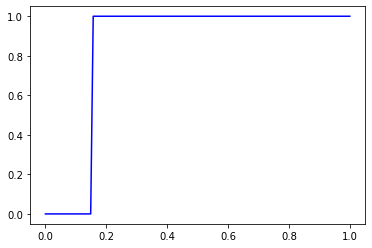

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.714974,0.525548,0.846499,0.904364,0.648256,0.776827
Validation,0.635525,0.455744,0.711531,0.815574,0.553497,0.656503



SVM
╠■■■■■■■■■╣


Weight?,Feature
+2.000,cough
+2.000,loss_of_smell
+1.998,loss_of_taste
+0.001,muscle_sore
+0.000,headache
+0.000,diabetes
+0.000,runny_nose
+0.000,fever
-0.000,htn
-0.000,fatigue


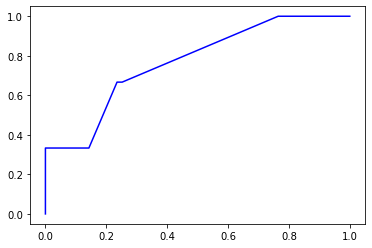

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.659560,0.467814,0.759408,0.851273,0.578498,0.697257
Validation,0.651494,0.461429,0.742412,0.841803,0.563526,0.685114



KNN
╠■■■■■■■■■╣


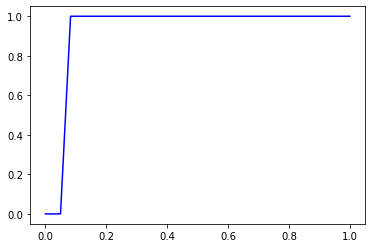

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.715110,0.505182,0.870932,0.925000,0.639315,0.759683
Validation,0.639229,0.419745,0.748326,0.859016,0.534921,0.659035



Logistic Regression
╠■■■■■■■■■╣


Weight?,Feature
+1.521,loss_of_smell
+1.424,loss_of_taste
+1.210,cough
+1.071,diabetes
+0.839,muscle_sore
+0.439,headache
+0.318,fever
+0.059,cancer
-0.075,fatigue
-0.101,htn


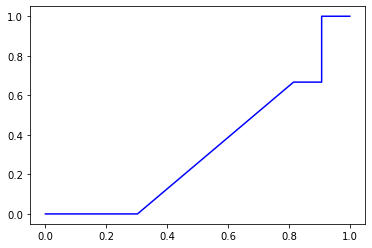

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.664788,0.487542,0.755370,0.842000,0.592473,0.700373
Validation,0.651497,0.473724,0.731005,0.829508,0.572115,0.679010


In [158]:
r_symptoms_comorb = pd.merge(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), comorb, left_index=True, right_index=True)
run_models(r_symptoms_comorb, y[r_symptoms_comorb.index], models, ratio_negatives_to_positives=1)

In [159]:
a = pd.Series(np.array([True, False, True, False]))
b = pd.Series(np.array([True, True, False, False]))

In [160]:
(a ^ b)

0    False
1     True
2     True
3    False
dtype: bool

Next step is to determine which features are useful in the case of each dataset, eliminating them one by one(and maybe applying normalization to the vitals).
After that, we select the 2 (first just 2) best models and somehow combine them to make an ensemble model.<br>
<i>Idea: One model for each metric so 4 models with the highest metrics and then figure out some boolean operation to combine them</i><br>
<i>Idea 2: The boolean operation can be found by using a Decision Tree. After all they are good at finding simple rules</i><br>
<i>Idea 3: The boolean operation taking the highest precision and the highest recall would be an AND. Maybe the inverse for another 2 metrics as well</i>

In [161]:
class CustomModel():

    def __init__(self):
        self.model_1 = LogisticRegression() #The best model (has very high accuracy and precission but not very good recall. Good for determining Positive results)
        self.model_2 = RandomForestClassifier() #The one with the best recall. Poor specificity and precision but high recall. Good for determining Negative results
        self.model_3 = XGBAdapter() #The one with high accuracy, and balanced recall and precision. If none of the other 2 are sure this is the tie breaker
        self.imputer = Imputer()
        
    def fit(self, data_x, data_y):
        self.imputer.fit(data_x, data_y)
        
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
        self.model_1.fit(data_1, data_y[data_1.index])
        self.model_2.fit(data_2, data_y[data_2.index])
        self.model_3.fit(data_3, data_y[data_3.index])
        
    def predict(self, data_x):
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
                
        preds_1 = self.model_1.predict(data_1)
        preds_2 = self.model_2.predict(data_2)
        preds_3 = self.model_3.predict(data_3)
        
        preds_1[preds_1 == "Positive"] = True
        preds_1[preds_1 == "Negative"] = False
        preds_2[preds_2 == "Positive"] = True
        preds_2[preds_2 == "Negative"] = False
        preds_3[preds_3 == "Positive"] = True
        preds_3[preds_3 == "Negative"] = False
        
        final_preds = ((preds_1)| (preds_2 & preds_3)) #If predicted positive by model 1 then we keep that prediction. If predicted negative by model 2, we try to keep it. In case preds1 is False and preds2 is True the final decision is with preds3
        
        #final_preds = np.sum(np.array([preds_1, preds_2, preds_3]), axis = 0)
        
        #final_preds[final_preds <=1] = "Negative"
        #final_preds[final_preds != "Negative" ] = "Positive"
        final_preds[final_preds == True] = "Positive"
        final_preds[final_preds == False] = "Negative"
        
        
        return final_preds

In [162]:
run_models(X, y, {"FirstEnsembleModel" : CustomModel()}, folds=10, ratio_negatives_to_positives=1)

FirstEnsembleModel
'CustomModel' object has no attribute 'predict_proba'


In [163]:
weights=(np.ones(y[ra_symptoms_vitals.index].shape) + (y[ra_symptoms_vitals.index]=="Negative"))

In [164]:
ensemble_models = {
    "LogisticVanilla" : LogisticRegression(),
    "LogisticStrongRegularization" : LogisticRegression(C=.5),
    "LogisticWeakRegularization" : LogisticRegression(C=2),
    "Logisctic"
    "AdaBoost" : AdaBoostClassifier(base_estimator=LogisticRegression())
}



In [165]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], {"Ada" : AdaBoostClassifier(base_estimator=LogisticRegression())}, folds=10, ratio_negatives_to_positives=1)

Ada
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.676491,0.581333,0.717913,0.771602,0.642361,0.734084
Validation,0.683245,0.586205,0.728111,0.780734,0.647969,0.734706


LogisticVanilla
╠■■■■■■■■■╣


Weight?,Feature
+1.952,loss_of_taste
+1.897,loss_of_smell
+1.157,muscle_sore
+1.030,cough
+0.963,diabetes
+0.567,headache
+0.519,labored_respiration
+0.464,chd
+0.331,sore_throat
+0.318,high_risk_exposure_occupation


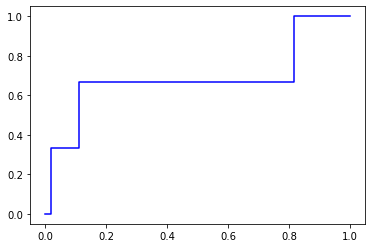

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.672334,0.570559,0.716370,0.774091,0.635086,0.740157
Validation,0.663786,0.546555,0.713287,0.781148,0.617779,0.728484



LogisticStrongRegularization
╠■■■■■■■■■╣


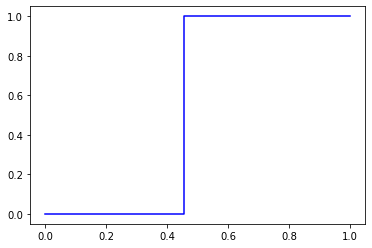

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.675788,0.580103,0.717389,0.771455,0.641418,0.747270
Validation,0.651061,0.556384,0.685493,0.745902,0.613449,0.712894



LogisticWeakRegularization
╠■■■■■■■■■╣


Weight?,Feature
+1.948,loss_of_smell
+1.159,loss_of_taste
+0.885,muscle_sore
+0.566,diabetes
+0.507,headache
+0.500,cough
+0.443,high_risk_exposure_occupation
+0.365,fever
+0.341,cough_severity
+0.255,temperature


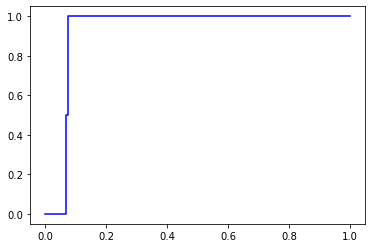

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.672743,0.568556,0.718302,0.776909,0.634588,0.738842
Validation,0.664580,0.544902,0.717546,0.784426,0.616796,0.733616



LogiscticAdaBoost
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.680743,0.591650,0.719892,0.769818,0.649439,0.743238
Validation,0.656400,0.567013,0.688228,0.745902,0.619770,0.713745


In [166]:
run_models(X.drop(columns=["sys", "dia"]), y, ensemble_models, ratio_negatives_to_positives=1)

In [167]:
ada_configurations = {
    "Ada Vanilla" : AdaBoostClassifier(),
    "Ada Logistic" : AdaBoostClassifier(base_estimator=LogisticRegression()),
    "Ada algo" : AdaBoostClassifier(algorithm="SAMME"),
    "Ada learning rate" : AdaBoostClassifier(learning_rate=.5),
    "Ada complete" : AdaBoostClassifier(base_estimator=LogisticRegression(C=.5), algorithm="SAMME", learning_rate=.5)
    
}

Ada Vanilla
╠■■■■■■■■■╣


Weight,Feature
0.2600 ± 0.8773,pulse
0.1600 ± 0.7332,temperature
0.1000 ± 0.6000,days_since_symptom_onset
0.0600 ± 0.4750,sats
0.0400 ± 0.3919,loss_of_taste
0.0400 ± 0.3919,rr
0.0200 ± 0.2800,diabetes
0.0200 ± 0.2800,cancer
0.0200 ± 0.2800,autoimmune_dis
0.0200 ± 0.2800,smoker


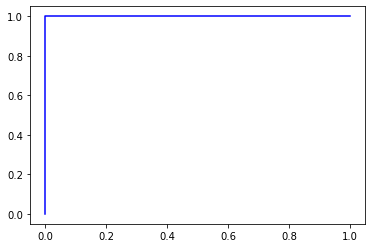

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.694153,0.608378,0.734295,0.779909,0.665296,0.769097
Validation,0.667871,0.554725,0.715773,0.781148,0.623954,0.720110



Ada Logistic
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.675243,0.583834,0.714434,0.766636,0.642503,0.743123
Validation,0.660912,0.562908,0.698028,0.759016,0.621285,0.721647



Ada algo
╠■■■■■■■■■╣


Weight,Feature
0.3206 ± 0.8980,loss_of_taste
0.1635 ± 0.6499,loss_of_smell
0.1042 ± 0.3919,pulse
0.0949 ± 0.2800,cough
0.0901 ± 0.4750,temperature
0.0842 ± 0.8000,autoimmune_dis
0.0379 ± 0.3919,muscle_sore
0.0311 ± 0.6499,days_since_symptom_onset
0.0239 ± 0.4750,asthma
0.0236 ± 0.2800,headache


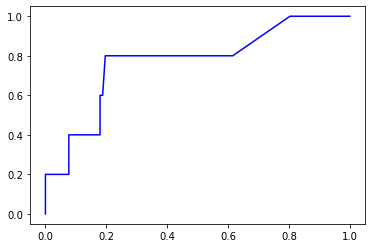

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.675242,0.601370,0.707436,0.749091,0.648252,0.740194
Validation,0.653946,0.576903,0.685690,0.731148,0.624003,0.709391



Ada learning rate
╠■■■■■■■■■╣


Weight,Feature
0.1600 ± 0.7332,temperature
0.1600 ± 0.7332,days_since_symptom_onset
0.1400 ± 0.6940,pulse
0.1000 ± 0.6000,rr
0.0400 ± 0.3919,cough_severity
0.0400 ± 0.3919,muscle_sore
0.0400 ± 0.3919,smoker
0.0400 ± 0.3919,fatigue
0.0400 ± 0.3919,high_risk_interactions
0.0400 ± 0.3919,loss_of_smell


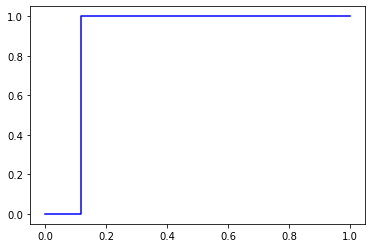

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.689744,0.589377,0.737676,0.790091,0.654893,0.763397
Validation,0.671949,0.549820,0.729126,0.794262,0.624681,0.734880



Ada complete
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.662059,0.629841,0.673467,0.694273,0.650770,0.709058
Validation,0.639209,0.616893,0.646024,0.661475,0.629054,0.682349


In [168]:
run_models(X.drop(columns=["sys", "dia"]), y, ada_configurations, ratio_negatives_to_positives=1)

Ada Vanilla
╠■■■■■■■■■╣


Weight,Feature
0.2000 ± 0.8000,pulse
0.2000 ± 0.8000,temperature
0.1800 ± 0.7684,pam
0.0800 ± 0.5426,rr
0.0400 ± 0.3919,days_since_symptom_onset
0.0400 ± 0.3919,sats
0.0200 ± 0.2800,wheezes
0.0200 ± 0.2800,rhonchi
0.0200 ± 0.2800,labored_respiration
0.0200 ± 0.2800,fever


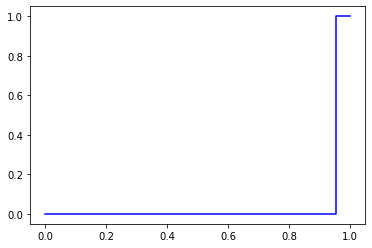

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.697997,0.593709,0.750137,0.802231,0.662757,0.769494
Validation,0.667722,0.553386,0.720232,0.782569,0.624136,0.711402



Ada Logistic
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.680750,0.585389,0.723857,0.776065,0.647011,0.739963
Validation,0.663146,0.565254,0.701339,0.761468,0.623123,0.712642



Ada algo
╠■■■■■■■■■╣


Weight,Feature
0.3257 ± 0.9708,temperature
0.2890 ± 0.7332,loss_of_smell
0.1083 ± 0.2800,cough
0.0946 ± 0.3919,pulse
0.0570 ± 0.3919,muscle_sore
0.0520 ± 0.2800,rhonchi
0.0384 ± 0.4750,loss_of_taste
0.0195 ± 0.2800,headache
0.0155 ± 0.2800,days_since_symptom_onset
0 ± 0.0000,sob


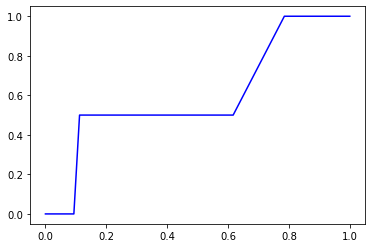

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.676693,0.592998,0.713287,0.760345,0.646896,0.733703
Validation,0.658529,0.570626,0.693011,0.746789,0.622308,0.710889



Ada learning rate
╠■■■■■■■■■╣


Weight,Feature
0.2400 ± 0.8542,temperature
0.1600 ± 0.7332,pam
0.1400 ± 0.6940,pulse
0.1000 ± 0.6000,sats
0.0800 ± 0.5426,days_since_symptom_onset
0.0600 ± 0.4750,cough
0.0400 ± 0.3919,rr
0.0400 ± 0.3919,headache
0.0400 ± 0.3919,loss_of_smell
0.0400 ± 0.3919,ctab


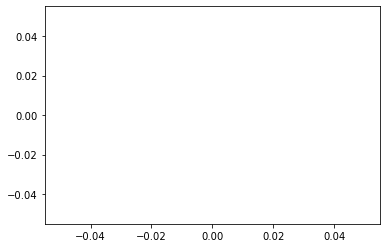

,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.690186,0.583662,0.742000,0.796653,0.652933,0.759300
Validation,0.659457,0.554237,0.702532,0.765138,0.618011,0.708607



Ada complete
╠■■■■■■■■■╣
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute


,Accuracy,Recall,Precision,Specificity,F1,ROC_AUC
Training,0.664520,0.622220,0.679689,0.706795,0.649610,0.713679
Validation,0.649409,0.609992,0.663175,0.688991,0.634618,0.698468


In [169]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], ada_configurations, ratio_negatives_to_positives=1)

## Sidequest: Understanding logistic regression

In [170]:
lr = LogisticRegression()
imp = Imputer()
imp.fit_transform(all_data, y[all_data.index])
lr.fit(all_data, y[all_data.index], sample_weight=(np.ones(y[all_data.index].shape) + (y[all_data.index]=="Negative")))

ValueError: could not convert string to float: 'Negative'

In [ ]:
lr_preds = lr.predict(all_data)

In [ ]:
manual_preds = np.dot(all_data, lr.coef_.transpose()) + lr.intercept_ #The dot product of coeficients and features plus the bias

In [ ]:
from math import exp
def logistic_function(value):
    return 1 / (1 + exp(-value))

In [ ]:
manual_preds.flatten()

In [ ]:
lfv = np.vectorize(logistic_function) #To vectorize means to apply it to vectors

In [ ]:
result = pd.Series(lfv(manual_preds).flatten())
result[result > .5] = "Positive"
result[result != "Positive"] = "Negative"

In [ ]:
a = np.array([[1,2,3,4,5],[2,4,6,8,10]])
b = np.ones((5,2))
b[:,1] *= 2

In [ ]:
np.dot(a, b)

In [ ]:
lfv(manual_preds)[lfv(manual_preds) > .5]

In [ ]:
explainer = shap.KernelExplainer(lr.predict_proba, np.zeros((1,all_data.columns.size)))

In [ ]:
shap_values = explainer.shap_values(all_data[y[all_data.index] == "Positive"].sample(1))

In [ ]:
shap_values

In [ ]:
shap.force_plot(explainer.expected_value[1], shap_values[1], all_data.columns)

In [ ]:
ra_symptoms_vitals.columns

In [ ]:
def calculate_shap_values(model, data_x):
    explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
    sample = data_x.sample(1)
    shap.initjs()
    display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))

In [ ]:
lr.fit(all_data, y[all_data.index])
calculate_shap_values(lr, all_data)

In [ ]:
y[all_data.index].value_counts()

In [ ]:
all_data["sats"]